In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import joblib
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics, accuracy_score
from imblearn.over_sampling import SMOTE
import shap
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [125]:
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')
data2 = data.copy()
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

C:\Users\adi_s\AppData\Local\Temp\ipykernel_12068\2287905068.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


One Hot encoded preprocessing

In [ ]:
X_temp = data.drop(columns=['label'])
y1 = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y1, test_size=0.2, random_state=42)

In [ ]:
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train: label
0    1774933
1     257104
Name: count, dtype: int64
Test label
0    443831
1     64179
Name: count, dtype: int64


In [ ]:
# Run best SMOTE Model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)
model1.load_model('./Models/saved_models/02/smote/007-128/PB_epoch_15.pth')
model1.test(test_loader)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

Summary Plot of NN

In [ ]:
# Create tensor background.
idx = torch.randperm(X_test_tensor.size(0))[:1000]
background = X_test_tensor[idx]
# I will be using test background so that the SMOTE and Standard model can be compared (will add later).
xp_nn = shap.DeepExplainer(model1, background)
# Just as an example. Usually we would check either correct or incorrect predictions here.
shap_nn = xp_nn.shap_values(background)
shap.summary_plot(shap_nn[:, :, 0], background, feature_names=X_test.columns, max_display=10)

Label Encoded preprocessing for Tree Model.

In [ ]:
# Label encode data2 (standard).
cols = ['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip']
data2[cols] = data2[cols].astype(str)
le_features = LabelEncoder()
for c in cols:
    data2[c] = le_features.fit_transform(data2[c])
# Keep label seperate for simplicity
le_label = LabelEncoder()
data2['attack_cat'] = le_label.fit_transform(data2['attack_cat'])

In [128]:
# Optionally process using 'label' for binary classification but make sure to remove attack_cat.
X_temp2 = data2.drop(columns=['label', 'attack_cat'])
y2 = data2['attack_cat']
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_temp2, y2, test_size=0.2, random_state=42)

In [85]:
# Optionally select XGboost model.
# Reduce estimators just to speed up processing for now.
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train2, y_train2)
y_pred2 = rf_model.predict(X_test2)
accuracy = accuracy_score(y_test2, y_pred2)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))

Accuracy: 0.9820

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.08      0.14       550
           1       0.50      0.08      0.14       477
           2       0.32      0.26      0.29      3315
           3       0.62      0.80      0.70      8732
           4       0.70      0.68      0.69      4784
           5       1.00      0.98      0.99     43110
           6       1.00      1.00      1.00    443831
           7       0.93      0.77      0.85      2850
           8       0.70      0.65      0.68       320
           9       0.62      0.12      0.20        41

    accuracy                           0.98    508010
   macro avg       0.69      0.54      0.57    508010
weighted avg       0.98      0.98      0.98    508010



In [129]:
# Optionally index the remaining data from the SMOTE model and use as test set (I will use this for shap).
temp = X_test2.copy()
temp['preds'] = model1.test_predicted
temp['actual'] = y_test2
X_test2_smote = temp[temp['preds'] == 1]
y_actual_smote = X_test2_smote['actual']
X_test2_smote = X_test2_smote.drop(columns=['preds', 'actual'])
y_pred3 = rf_model.predict(X_test2_smote)
accuracy = accuracy_score(y_actual_smote, y_pred3)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_actual_smote, y_pred3))

Accuracy: 0.7846

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.05      0.09       550
           1       0.61      0.05      0.10       477
           2       0.28      0.06      0.10      3315
           3       0.51      0.80      0.62      8732
           4       0.41      0.34      0.37      4784
           5       0.99      0.98      0.99     43110
           6       0.32      0.38      0.34      6141
           7       0.91      0.59      0.71      2850
           8       0.34      0.47      0.40       320
           9       1.00      0.07      0.14        41

    accuracy                           0.78     70320
   macro avg       0.59      0.38      0.39     70320
weighted avg       0.79      0.78      0.77     70320



NN For quick Summary plot.

Tree Model

In [130]:
# Calculate shap values (using SMOTE model test)
# The background determines the baseline. Do you want to evaluate how the train data generalises to test data then use a train and test background
# and compare in shap visualisations (make sure to use the same index).
# NOTE: I do not know how this might impact the tree model. It depends if the tree model reconstructs the tree for the test set based on weighths
# or uses the tree from train set (unmodified).
# Lets use the test background for now as it represents the distribution of the predicted set.

# Lets index just DoS and make visualisations for incorrect labels.
# first we need to add actual labels and predicted labels back.
X_test2_smote['actual'] = y_actual_smote
X_test2_smote['preds'] = y_pred3

# Now we take a sample for the background (this is why we had to add the predictions first).
# First lets check the value counts for actual.
print(X_test2_smote['actual'].value_counts())
# Ok we see a problem here. We have way too many generic samples but we face the same issues in normal data with Normal labels.

actual
5    43110
3     8732
6     6141
4     4784
2     3315
7     2850
0      550
1      477
8      320
9       41
Name: count, dtype: int64


In [131]:
# Ideally we want a larger background to avoid this error. But lets move forward with this and make sure we get all labels.
ss = 0
rs = 0
background2 = None
while ss < 10:
    samplex = X_test2_smote.sample(n=1000, random_state=rs)
    rs += 1
    ss = len(samplex['actual'].value_counts())
    print(len(samplex['actual'].value_counts()))
    if ss == 10:
        background2 = samplex
print(background2['actual'].value_counts())

9
10
actual
5    623
3    125
6     86
4     70
7     38
2     37
0     10
1      7
8      2
9      2
Name: count, dtype: int64


In [132]:
# Now we need to remove the predictions and store them before making the background.
actual = background2['actual']
predicted = background2['preds']
background2 = background2.drop(columns=['actual', 'preds'])
xp_tree = shap.TreeExplainer(rf_model, background2)

In [ ]:
actual = le_label.inverse_transform(actual)
predicted = le_label.inverse_transform(predicted)
print(actual)
print(predicted)

['Fuzzers' 'Normal' 'Generic' 'DoS' 'Generic' 'Generic' 'Generic'
 'Generic' 'Generic' 'Normal' 'Generic' 'Generic' 'Generic' 'Generic'
 'Fuzzers' 'Generic' 'Exploits' 'Generic' 'Generic' 'Normal' 'Generic'
 'Generic' 'Generic' 'Generic' 'Generic' 'Generic' 'Normal' 'Generic'
 'Exploits' 'Generic' 'Generic' 'Generic' 'Generic' 'Generic' 'Generic'
 'Exploits' 'Generic' 'Normal' 'Fuzzers' 'Analysis' 'Reconnaissance'
 'Generic' 'Generic' 'Generic' 'Normal' 'Generic' 'Generic' 'Generic'
 'Generic' 'Fuzzers' 'Generic' 'Generic' 'Exploits' 'Generic' 'Normal'
 'Generic' 'Shellcode' 'Generic' 'Reconnaissance' 'Fuzzers' 'Generic'
 'Generic' 'Fuzzers' 'Fuzzers' 'Generic' 'Reconnaissance' 'Generic'
 'Exploits' 'Generic' 'Generic' 'Generic' 'Generic' 'Generic' 'Generic'
 'Exploits' 'Backdoor' 'Normal' 'Exploits' 'Exploits' 'Exploits' 'Generic'
 'Generic' 'Generic' 'Exploits' 'Generic' 'Generic' 'Normal' 'Exploits'
 'Fuzzers' 'DoS' 'Normal' 'Generic' 'Fuzzers' 'Exploits' 'Generic'
 'Generic' 'DoS' 

In [134]:
# Another issue is that we made no predictions on Worms successfully. - Maybe we can fix this using shap or model optimisation.
print(pd.DataFrame(predicted).value_counts())

0             
Generic           618
Exploits          191
Normal            106
Fuzzers            51
Reconnaissance     25
Shellcode           5
DoS                 3
Analysis            1
Name: count, dtype: int64


In [137]:
# Ok now we can select something like incorrect predictions in DoS.
# There is probably a more efficient way but once again lets map our encodings back to the original data for DoS.
preds = X_test2_smote['preds']
actual = X_test2_smote['actual']
preds = le_label.inverse_transform(preds)
actual = le_label.inverse_transform(actual)

In [138]:
# Add them back in for indexing (By the way when doing this transformation for values in a feature you will need to make a function or loop).
X_test2_smote['preds'] = preds
X_test2_smote['actual'] = actual

In [142]:
# Lets collect our DoS predictions.
X_test2_dos = X_test2_smote[(X_test2_smote['actual'] == 'DoS') & (X_test2_smote['preds'] != 'DoS')]
print(len(X_test2_dos))

3124


In [143]:
# Ok lets take a sample of 1000 for a quicker calculation of shap values.
X_test2_dos = X_test2_dos.sample(n=1000)

In [145]:
# Lets remove our labels for now and store them.
preds = X_test2_dos['preds']
actual = X_test2_dos['actual']
X_test2_dos = X_test2_dos.drop(columns=['preds', 'actual'])
# Calculate shap.
shap_values = xp_tree(X_test2_dos)

100%|===================| 9987/10000 [00:46<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.081119, while the model output was 0.163333. If this difference is acceptable you can set check_additivity=False to disable this check.

In [149]:
# So we got the additivity error again. This could cause problems for us so try to to use XGboost here and it will not be a problem.
# We will continue without the additivity check for the purpose of the example.
shap_values = xp_tree(X_test2_dos, check_additivity=False)

100%|===================| 9982/10000 [00:47<00:00]        

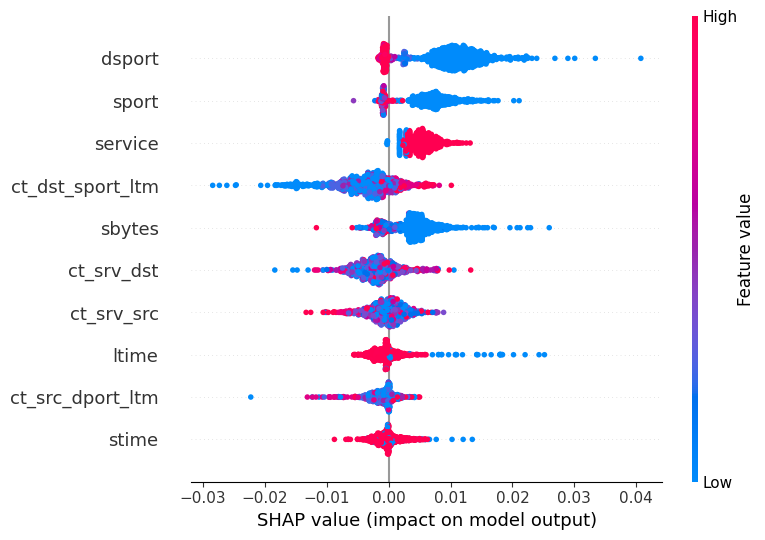

In [151]:
# Lets make a quick summary plot.
# This checks Normal features (0).
shap.summary_plot(shap_values[:, :, 0], X_test2_dos, max_display=10)

In [ ]:
# Ok so now lets move onto dependency plots.
# Step 1: use .unique() to find a categorical variable that potentially has around 30-40 unique values. - We dont want to overdo this just
# use it as an example. - If you cant find any just use ports for the purpose of an example but there is a lot.
# Step 2: Plot a decision plot normally with label encoded values.
# dependency_plot(feature (e.g. 0), shap array (e.g shap_value[:, feature must match first feature value, 0], x_test_smote[:, feature_value]))
# Additionally add an interaction index.
# Step 3: Convert the categorical variable using le_features - this might be a bit difficult you may have to make a loop to convert all categorical ffeatures in the mapping.
# Step 4: Replot in the dependency_plot. Now the plot will automatically detect it is a category and arrange it accordingly.
# Step 5: Take the absolute sum of shapely values for the categorical feature row. Or alternatively use the average shapely values then convert to the absolute value.
# NOTE: You want to keep your original shap value array aswell.
# Step 6: Find the values with highest of these shapely values.
# Step 7: Convert all other values below the top 10 to the string name 'Other' inside X_test_smote - maybe make a new df.
# Step 8: Replot - the mapping will be done automatically through the dataframe and original shap value array.
# Step 9: Share your thoughts about findings.